In [77]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev
import seaborn as sns

In [78]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [79]:

def stats_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics, filter_na = True):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT or DeepJDOT
    """

    metric_stats = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")

        score_df = pd.read_csv(score_path, header=0, index_col=None)

        # get target metric
        metric_stats.append(get_target_stats(score_df, eval_metric, trans_metric, filter_na))

    return metric_stats

In [80]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [81]:
score_dir = f"/home/{user_id}/OTTEHR/outputs/mimic/"

# eval_metric = 'MAE'
eval_metric = 'RMSE'

group_name = 'insurance'
groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

# group_name = 'marital_status'
# groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

trans_metrics = ['OT', 'TCA', 'CA', 'GFK']



medians for each method is: [ 0.39862333 -0.00187141  0.03466133 -0.61968189]
          OT       TCA        CA       GFK
0   0.293697 -0.011205 -0.100029 -0.467590
1   0.265343 -0.009296 -0.074114 -0.422806
2   0.431164  0.022994 -0.057592 -0.659765
3   0.450228  0.004912 -0.105554 -0.813098
4   0.521004  0.000405  0.107994 -0.983880
..       ...       ...       ...       ...
95  0.543218 -0.020856  0.083984 -0.945884
96  0.296501  0.001421 -0.218073 -0.482768
97  0.523995 -0.017016  0.067365 -0.953392
98  0.361793 -0.019395  0.074936 -0.560218
99  0.279737  0.021362 -0.017820 -0.384689

[100 rows x 4 columns]


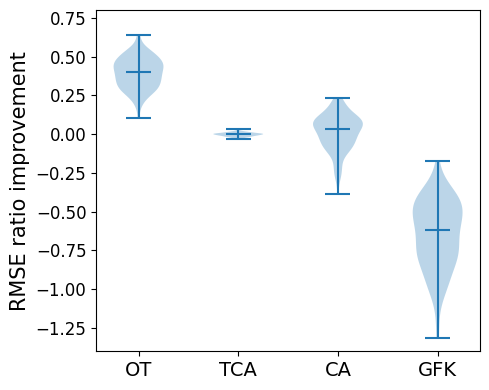

In [82]:
# Overall, for all groups
improve_ratio_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        improve_ratio_combined.extend(improve_ratios)

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = improve_ratio_combined[i]
# print(np.median(trans_metric_dict['GWOT']))
data = pd.DataFrame(trans_metric_dict)
print("medians for each method is:", np.median(data, axis=0))
print(data)


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"{eval_metric} ratio improvement", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels( labels=trans_metrics, fontsize=14)
plt.ylim(-1.4, 0.8)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_ratio.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [83]:
def print_latex(source, target, ratios, percent):
    """ 
    Print latex for ratios
    """

    print_str = f"{source.title()} & {target.title()}"
    for ratio in ratios:
        if percent:
            print_str += f' & {median(ratio)*100:.1f}({stdev(ratio)*100:.1f})'
        else: 
            base = 10**5
            print_str += f' & {median(ratio)/base:.1f}({stdev(ratio)/base:.1f})'
    print_str += ' \\\ \hline'
    print(print_str)
    

In [84]:
for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        # print(f"group 1: {group_1}, group_2: {group_2}")
        # mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
        # print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        # print(rmse_improve_ratios)
        # print_median_std(rmse_improve_ratios, trans_metrics, eval_metric)
        print_latex(group_1, group_2, improve_ratios, percent=True)

Private & Self_Pay & 9.0(6.9) & -0.3(0.7) & -1.9(9.2) & -9.7(8.2) \\ \hline
Government & Self_Pay & 10.3(8.7) & 0.0(0.7) & -0.3(8.6) & -11.3(12.1) \\ \hline
Government & Private & 25.4(12.8) & 0.9(2.1) & -0.8(12.6) & -35.9(24.2) \\ \hline
Medicare & Self_Pay & 23.3(12.1) & 0.2(0.6) & -3.0(8.8) & -29.4(20.7) \\ \hline
Medicare & Private & 45.0(11.3) & -0.1(1.5) & -2.0(11.0) & -75.0(31.0) \\ \hline
Medicare & Government & 42.6(12.1) & -0.2(1.3) & 1.9(10.7) & -69.8(29.6) \\ \hline
Medicaid & Self_Pay & 8.8(7.2) & -0.2(0.7) & -1.6(7.0) & -9.4(8.4) \\ \hline
Medicaid & Private & 20.7(12.5) & 0.4(1.8) & 1.2(10.0) & -27.6(21.1) \\ \hline
Medicaid & Government & 21.0(12.1) & 0.3(1.1) & -2.4(11.0) & -25.5(18.2) \\ \hline
Medicaid & Medicare & 7.0(9.5) & 0.1(0.4) & -2.2(9.6) & -8.0(12.5) \\ \hline


median is: 7.545557650693145, 7.533145749999999


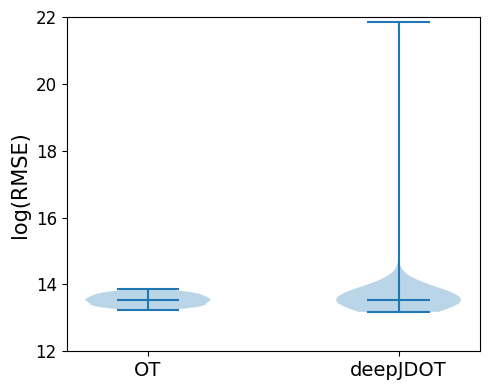

In [85]:
# Present the overall performance for deepJDOT and OTTEHR
trans_metrics = ['OT', 'deepJDOT']
stats_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)
        stats_combined.extend(stats)

# fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_deepJDOT.pdf")

# plt.tight_layout()
# plt.savefig(fig_path, bbox_inches='tight')
# plt.show()

base = 10**5
print(f"median is: {median(stats_combined[0])/base}, {median(stats_combined[1])/base}")

# Apply log to stats_combined
stats_combined[0] = [np.log(x) for x in stats_combined[0]]
stats_combined[1] = [np.log(x) for x in stats_combined[1]]

# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot([stats_combined[0], stats_combined[1]], showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"log({eval_metric})", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=trans_metrics, fontsize=14)
plt.ylim(12, 22)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_deepJDOT.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [86]:
# Calculate the pairwise performance for deepJDOT and OTTEHR


for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)

        print_latex(group_1, group_2, stats, percent=False)

Private & Self_Pay & 12.0(3.0) & 11.9(2.9) \\ \hline
Government & Self_Pay & 10.7(2.5) & 10.9(2.5) \\ \hline
Government & Private & 11.1(2.6) & 10.1(10.1) \\ \hline
Medicare & Self_Pay & 7.9(2.0) & 8.4(14.7) \\ \hline
Medicare & Private & 8.2(1.7) & 7.5(2.1) \\ \hline
Medicare & Government & 8.0(1.9) & 7.9(1319.3) \\ \hline
Medicaid & Self_Pay & 13.6(3.7) & 14.1(5.6) \\ \hline
Medicaid & Private & 13.3(3.6) & 13.9(1359.8) \\ \hline
Medicaid & Government & 12.8(3.2) & 13.6(156.6) \\ \hline
Medicaid & Medicare & 13.9(3.6) & 13.5(4.1) \\ \hline
